## 2. Machine Learning for Regression


In [1]:
# %pip install pandas numpy

import pandas as pd
import numpy as np

## 2.2 Data preparation

In [2]:
# data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv'

In [3]:
# !wget $data 

In [4]:
df = pd.read_csv('data.csv')
df.head()  ##Look for header inconsistency

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


### Cleaning header (make it consistence)

In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.columns  #.columns is a data structure of pandas, similar to series

Index(['make', 'model', 'year', 'engine_fuel_type', 'engine_hp',
       'engine_cylinders', 'transmission_type', 'driven_wheels',
       'number_of_doors', 'market_category', 'vehicle_size', 'vehicle_style',
       'highway_mpg', 'city_mpg', 'popularity', 'msrp'],
      dtype='object')

### Cleaning values, let's take 'make' column as example

In [6]:
df['make'].str.lower().str.replace(' ', '_')

0            bmw
1            bmw
2            bmw
3            bmw
4            bmw
          ...   
11909      acura
11910      acura
11911      acura
11912      acura
11913    lincoln
Name: make, Length: 11914, dtype: object

### However, we need to apply this to all the column values, not only for make column. First detect the string column

In [7]:
df.dtypes  ##List column's value type

make                  object
model                 object
year                   int64
engine_fuel_type      object
engine_hp            float64
engine_cylinders     float64
transmission_type     object
driven_wheels         object
number_of_doors      float64
market_category       object
vehicle_size          object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
popularity             int64
msrp                   int64
dtype: object

### Get only string types, which is object

In [8]:
df.dtypes == 'object'
df.dtypes[df.dtypes == 'object']  ## Get only object type column

make                 object
model                object
engine_fuel_type     object
transmission_type    object
driven_wheels        object
market_category      object
vehicle_size         object
vehicle_style        object
dtype: object

In [9]:
strings = list(df.dtypes[df.dtypes == 'object'].index) ## Get the index of the series and convert it to list 
strings

['make',
 'model',
 'engine_fuel_type',
 'transmission_type',
 'driven_wheels',
 'market_category',
 'vehicle_size',
 'vehicle_style']

### Loop through all string columns AND clean the columns value, just like we did for make column earlier

In [10]:
for col in strings:
    df[col] = df[col].str.lower().str.replace(' ', '_')
df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500


In [11]:
df.dtypes

make                  object
model                 object
year                   int64
engine_fuel_type      object
engine_hp            float64
engine_cylinders     float64
transmission_type     object
driven_wheels         object
number_of_doors      float64
market_category       object
vehicle_size          object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
popularity             int64
msrp                   int64
dtype: object

## 2.3 Exploratory data analysis

Exploratory data analysis (EDA) is an essential step in the data analysis process. It involves summarizing and visualizing the main characteristics of a dataset to gain insights and identify patterns or trends. By summarizing, visualizing, and cleaning the data, researchers can uncover patterns, identify relationships, and make informed decisions

### Before doing EDA, let's look at each column and print some values

In [12]:
for col in df.columns:
    print(col)
    print(df[col].head())
    print()  #new line

make
0    bmw
1    bmw
2    bmw
3    bmw
4    bmw
Name: make, dtype: object

model
0    1_series_m
1      1_series
2      1_series
3      1_series
4      1_series
Name: model, dtype: object

year
0    2011
1    2011
2    2011
3    2011
4    2011
Name: year, dtype: int64

engine_fuel_type
0    premium_unleaded_(required)
1    premium_unleaded_(required)
2    premium_unleaded_(required)
3    premium_unleaded_(required)
4    premium_unleaded_(required)
Name: engine_fuel_type, dtype: object

engine_hp
0    335.0
1    300.0
2    300.0
3    230.0
4    230.0
Name: engine_hp, dtype: float64

engine_cylinders
0    6.0
1    6.0
2    6.0
3    6.0
4    6.0
Name: engine_cylinders, dtype: float64

transmission_type
0    manual
1    manual
2    manual
3    manual
4    manual
Name: transmission_type, dtype: object

driven_wheels
0    rear_wheel_drive
1    rear_wheel_drive
2    rear_wheel_drive
3    rear_wheel_drive
4    rear_wheel_drive
Name: driven_wheels, dtype: object

number_of_doors
0    2.0
1   

### Let's find unique value

In [13]:
for col in df.columns:
    # print(col)
    # print(df[col].unique()[:5]) # print only first five unique value
    print(f"number of unique values in {col} column: {df[col].nunique()}")  #notice the nunique vs unique. n means count
    # print()

number of unique values in make column: 48
number of unique values in model column: 914
number of unique values in year column: 28
number of unique values in engine_fuel_type column: 10
number of unique values in engine_hp column: 356
number of unique values in engine_cylinders column: 9
number of unique values in transmission_type column: 5
number of unique values in driven_wheels column: 4
number of unique values in number_of_doors column: 3
number of unique values in market_category column: 71
number of unique values in vehicle_size column: 3
number of unique values in vehicle_style column: 16
number of unique values in highway_mpg column: 59
number of unique values in city_mpg column: 69
number of unique values in popularity column: 48
number of unique values in msrp column: 6049


In [14]:
df

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11909,acura,zdx,2012,premium_unleaded_(required),300.0,6.0,automatic,all_wheel_drive,4.0,"crossover,hatchback,luxury",midsize,4dr_hatchback,23,16,204,46120
11910,acura,zdx,2012,premium_unleaded_(required),300.0,6.0,automatic,all_wheel_drive,4.0,"crossover,hatchback,luxury",midsize,4dr_hatchback,23,16,204,56670
11911,acura,zdx,2012,premium_unleaded_(required),300.0,6.0,automatic,all_wheel_drive,4.0,"crossover,hatchback,luxury",midsize,4dr_hatchback,23,16,204,50620
11912,acura,zdx,2013,premium_unleaded_(recommended),300.0,6.0,automatic,all_wheel_drive,4.0,"crossover,hatchback,luxury",midsize,4dr_hatchback,23,16,204,50920


### Distribution of price

In [16]:
# %pip install seaborn matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## Display plot in notebook
%matplotlib inline

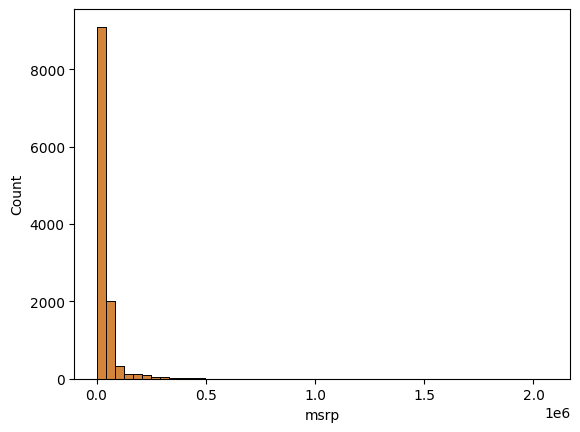

In [18]:
sns.histplot(df.msrp, bins=50)   #bins number of bars in histogram
plt.show()

From graph, we see that lots of cars are cheap and only few are expensive. That means it is LONG-TAIL Distribution (many prices in a small range, but a few prices in a wide range) we need to zoom in a bit to ignore the long tail with too less datapoints

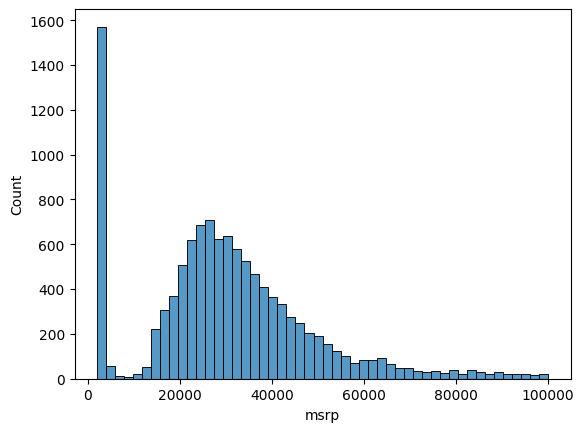

In [19]:
sns.histplot(df.msrp[df.msrp < 100000], bins=50)
plt.show()

This kind of distribution (long tail, and the peak) is not good for ML models, because this distribution will confuse them. There is a way to get rid of the long tail, by applying logarithm (it compresses large values while spreading out smaller ones) to the price. This results in more compact values.

In [22]:
#np.log([0, 1,10,1000,100000])
# problem with logarithm is when we have a 0, because log(0) does not exist
#np.log([0 + 1, 1 + 1, 10 + 1, 1000 + 1, 100000 + 1])
# Output: array([ 0.        ,  0.69314718,  2.39789527,  6.90875478, 11.51293546])
# 
# In order to not always add 1 there is a NumPy function
#np.log1p([0, 1,10,1000,100000])
# Output: array([ 0.        ,  0.69314718,  2.39789527,  6.90875478, 11.51293546])

price_logs = np.log1p(df.msrp)
price_logs

0        10.739349
1        10.612779
2        10.500977
3        10.290483
4        10.448744
           ...    
11909    10.739024
11910    10.945018
11911    10.832122
11912    10.838031
11913    10.274913
Name: msrp, Length: 11914, dtype: float64

In [23]:
sns.histplot(price_logs, bins=50)

<Axes: xlabel='msrp', ylabel='Count'>

You can see the long tail is gone and you see a nice bell curve shape of a so called normal distribution, what is ideal for ML models. But still there is the strange peak. This could be the minimum price of $1,000 of the platform.

### Missing values

The sum function sums across columns and shows for each column how much missing values (Nan) are there. This information is important when training a model.

In [23]:
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

## 2.4 Setting up the validation framework

Let's draw it

To validate the model, we take the dataset and split it into three parts (train-val-test / 60-20-20). 
This means that we train the model on the training dataset, check if it works fine on the validation dataset, and leave the test dataset for the end.
For each of these three parts, we create the feature matrix X and the target variable y (Xtrain, ytrain, Xval, yval, Xtest, ytest). 
So, what we need to do is calculate how much 20% is.

In [24]:
len(df) # Number of records of the whole dataset

11914

In [25]:
int(len(df) * 0.2) #Calculate 20% of whole dataset

2382

In [26]:
#Splitting data set intto three 

n = len(df)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

n, n_val+n_test+n_train

(11914, 11914)

In [27]:
n_val, n_test, n_train #sizes of our dataframes

(2382, 2382, 7150)

In [28]:
#df.iloc[[10, 0, 3, 5]]  #iloc used to select row number

In [29]:
#Dataset has been split into three
df_train = df.iloc[:n_train]  #get data upto 7149
df_val = df.iloc[n_train:n_train+n_val] #get data from 7150 to 9531
df_test = df.iloc[n_train+n_val:] #get data from 9532 to rest

In [30]:
df_train

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7145,mazda,navajo,1994,regular_unleaded,160.0,6.0,manual,four_wheel_drive,2.0,NaN,compact,2dr_suv,18,14,586,2000
7146,mazda,navajo,1994,regular_unleaded,160.0,6.0,manual,four_wheel_drive,2.0,NaN,compact,2dr_suv,18,14,586,2000
7147,lincoln,navigator,2015,regular_unleaded,365.0,6.0,automatic,four_wheel_drive,4.0,luxury,large,4dr_suv,20,15,61,65055
7148,lincoln,navigator,2015,regular_unleaded,365.0,6.0,automatic,four_wheel_drive,4.0,luxury,large,4dr_suv,19,15,61,67220


In [31]:
df_val

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
7150,lincoln,navigator,2015,regular_unleaded,365.0,6.0,automatic,rear_wheel_drive,4.0,luxury,large,4dr_suv,20,15,61,63645
7151,lincoln,navigator,2016,regular_unleaded,380.0,6.0,automatic,rear_wheel_drive,4.0,luxury,large,4dr_suv,22,16,61,63195
7152,lincoln,navigator,2016,regular_unleaded,380.0,6.0,automatic,four_wheel_drive,4.0,luxury,large,4dr_suv,19,15,61,76650
7153,lincoln,navigator,2016,regular_unleaded,380.0,6.0,automatic,four_wheel_drive,4.0,luxury,large,4dr_suv,19,15,61,69135
7154,lincoln,navigator,2016,regular_unleaded,380.0,6.0,automatic,rear_wheel_drive,4.0,luxury,large,4dr_suv,20,15,61,65560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9527,chevrolet,silverado_1500,2015,flex-fuel_(unleaded/e85),285.0,6.0,automatic,four_wheel_drive,4.0,flex_fuel,large,crew_cab_pickup,22,17,1385,37380
9528,chevrolet,silverado_1500,2015,regular_unleaded,355.0,8.0,automatic,rear_wheel_drive,4.0,NaN,large,extended_cab_pickup,23,16,1385,40100
9529,chevrolet,silverado_1500,2015,regular_unleaded,355.0,8.0,automatic,rear_wheel_drive,4.0,NaN,large,crew_cab_pickup,23,16,1385,42560
9530,chevrolet,silverado_1500,2015,regular_unleaded,355.0,8.0,automatic,rear_wheel_drive,4.0,NaN,large,crew_cab_pickup,23,16,1385,42860


In [32]:
df_test

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
9532,chevrolet,silverado_1500,2015,regular_unleaded,355.0,8.0,automatic,rear_wheel_drive,4.0,NaN,large,crew_cab_pickup,23,16,1385,47575
9533,chevrolet,silverado_1500,2015,flex-fuel_(unleaded/e85),285.0,6.0,automatic,rear_wheel_drive,4.0,flex_fuel,large,extended_cab_pickup,24,18,1385,31940
9534,chevrolet,silverado_1500,2015,flex-fuel_(unleaded/e85),285.0,6.0,automatic,rear_wheel_drive,4.0,flex_fuel,large,crew_cab_pickup,24,18,1385,38335
9535,chevrolet,silverado_1500,2015,flex-fuel_(unleaded/e85),285.0,6.0,automatic,rear_wheel_drive,4.0,flex_fuel,large,extended_cab_pickup,24,18,1385,35870
9536,chevrolet,silverado_1500,2015,flex-fuel_(unleaded/e85),285.0,6.0,automatic,rear_wheel_drive,2.0,flex_fuel,large,regular_cab_pickup,24,18,1385,28155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11909,acura,zdx,2012,premium_unleaded_(required),300.0,6.0,automatic,all_wheel_drive,4.0,"crossover,hatchback,luxury",midsize,4dr_hatchback,23,16,204,46120
11910,acura,zdx,2012,premium_unleaded_(required),300.0,6.0,automatic,all_wheel_drive,4.0,"crossover,hatchback,luxury",midsize,4dr_hatchback,23,16,204,56670
11911,acura,zdx,2012,premium_unleaded_(required),300.0,6.0,automatic,all_wheel_drive,4.0,"crossover,hatchback,luxury",midsize,4dr_hatchback,23,16,204,50620
11912,acura,zdx,2013,premium_unleaded_(recommended),300.0,6.0,automatic,all_wheel_drive,4.0,"crossover,hatchback,luxury",midsize,4dr_hatchback,23,16,204,50920


After the divisions, there is one crucial problem, the sequential problem. That’s a problem when there is an order in the dataset. 
That means we need to shuffle, otherwise, there are BMWs only in one dataset

In [37]:
idx = np.arange(n)
idx #See, the output is sequential, we need to shuffle

array([    0,     1,     2, ..., 11911, 11912, 11913])

In [38]:
# Let's shuffle. To make it reproducible, we may use seed
# np.random.seed(2)
np.random.shuffle(idx)
idx

array([ 9802,  4106,  6689, ...,  8484, 11743,  2633])

Using this shuffled index we can create our shuffled datasets for training, validation and for testing.

In [40]:
df_train = df.iloc[idx[:n_train]]  #select multiple columns from idx. It selects shuffled columns index for all rows in the DataFrame.
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

Now there is no order in the index column so we can reset index and drop the old index column.

In [41]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [42]:
df_train.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,gmc,sonoma,2002,regular_unleaded,190.0,6.0,manual,four_wheel_drive,3.0,NaN,compact,extended_cab_pickup,16,12,549,19675
1,cadillac,escalade_esv,2015,flex-fuel_(unleaded/e85),420.0,8.0,automatic,rear_wheel_drive,4.0,"flex_fuel,luxury,performance",large,4dr_suv,22,15,1624,92275
2,chevrolet,malibu,2017,regular_unleaded,160.0,4.0,automatic,front_wheel_drive,4.0,NaN,midsize,sedan,36,27,1385,23225
3,buick,verano,2015,regular_unleaded,180.0,4.0,automatic,front_wheel_drive,4.0,NaN,midsize,sedan,32,21,155,27050
4,chevrolet,silverado_1500,2015,flex-fuel_(unleaded/e85),285.0,6.0,automatic,rear_wheel_drive,4.0,flex_fuel,large,extended_cab_pickup,24,18,1385,35870


In [43]:
len(df_train), len(df_val), len(df_test)

(7150, 2382, 2382)

Remember that we should apply the log1p transformation to the price column to help the model perform well.

In [44]:
y_train = np.log1p(df_train.msrp.values)
y_val = np.log1p(df_val.msrp.values)
y_test = np.log1p(df_test.msrp.values)

In [45]:
len(y_train)

7150

We should remove msrp values from dataframes (df_train, df_val, df_test) to make sure that, we don’t accidentally use it for training purposes. Since it has long tail distribution which will confuses the model

In [46]:
del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

## 2.5 Linear regression

Source: https://knowmledge.com/2023/09/20/ml-zoomcamp-2023-machine-learning-for-regression-part-4/

Linear regression is a way to predict numbers based on some input information. For example, if we want to predict the **price of a car**, we can use details like **its age, mileage, and horsepower**.  

### The General Idea:  
- **X (Feature Matrix)** → All the details about many cars (like a table with rows and columns).  
- **y (Target)** → The price of each car.  
- **g (Model)** → The linear regression formula that learns the relationship between features and price.  

### Looking at One Car:  
Instead of looking at many cars, let’s focus on just **one car**.  
- **xi** → The details of that one car (e.g., age, mileage, horsepower).  
- **yi** → The price of that car.  
- **g(xi)** → The model’s prediction for that car’s price.  

So, the model takes **xi (car details)** and predicts **yi (price)** using a formula.

In [47]:
df_train.iloc[10]

make                        mitsubishi
model                           galant
year                              2010
engine_fuel_type      regular_unleaded
engine_hp                        160.0
engine_cylinders                   4.0
transmission_type            automatic
driven_wheels        front_wheel_drive
number_of_doors                    4.0
market_category                    NaN
vehicle_size                   midsize
vehicle_style                    sedan
highway_mpg                         30
city_mpg                            21
popularity                         436
Name: 10, dtype: object

We take as an example the characteristic enging_hp, city_mpg, and popularity.

In [48]:
xi = [180, 11, 1851]

That’s almost everything we need to implement g(xi) ~ yi:

xi = (180, 11, 1851) with i = 10

need to implement the function g(xi2,xi2, … , xin) ~ yi

In [49]:
# in code this would look like --> this is what we want to implement
 
def g(xi):
    # do something and return the predicted price
    return 10000
 
g(xi)
# Output: 10000

10000

This function g is still not very useful, because it always returns a fixed price. 

We need to implement the function g(xi) = w0 + w1xi1 + w2xi2 + w3xi3 with w0 as bias term and w1, w2, and w3 as weights. This formula can be written as

https://knowmledge.com/wp-content/uploads/2023/09/linregex-1.jpg


However, the formula of linear regression in python looks like this since index start from 0 instead of 1
https://knowmledge.com/wp-content/uploads/2023/09/linreggen-1.jpg

The following snippet shows the implementation of the g-function (renamed as linear_regression)

In [50]:
def linear_regression(xi):
    n = len(xi)

    pred = w0

    for j in range(n):
        pred = pred + w[j] * xi[j]

    return pred

In [51]:
# sample values for w0 and w and the given xi
xi = [180, 11, 1851]
w0 = 0
w = [1, 1, 1]

In [52]:
linear_regression(xi)

2042

In [53]:
# try some other values
w0 = 7.17
w = [0.01, 0.04, 0.002]
linear_regression(xi)

13.112

#### What does this actually mean?

We’ve just implemented the formula as mentioned before with given values:

7.17 + 180*0.01 + 11*0.04 + 1851*0.002 = 13.112

- w0 = 7.17 bias term = the prediction of a car, if we don’t know anything about this
- engine_hp: 180 * 0.01 that means in this case per 100 hp the price will increase by $1
- city_mpg: 11 * 0.04 that means analog to hp, the more gallons the higher the price will be
- popularity: 1851 * 0.002 analog, but it doesn’t seem that it’s affecting the price too much, so for every extra mention on twitter the car becomes just a little bit more expensive

There is still one important step to do. Because we logarithmized (log(y+1)) the price at the beginning, we now have to undo that. This gives us the predicted price in $.

#### Get the real prediction for the price in $
We do "-1" here to undo the "+1" inside the log. Shortcut for -1

np.expm1(13.112)

Just for checking

In [54]:
np.log1p(494844.0686835755)

np.float64(13.112)

## 2.6 Linear regression vector form

Source: https://knowmledge.com/2023/09/20/ml-zoomcamp-2023-machine-learning-for-regression-part-5/

Now we will generalize to a vector form of what we did in last. 

That means coming back from only one observation xi (of one car) to the whole feature matrix X.

https://knowmledge.com/wp-content/uploads/2023/09/linreggen-1.jpg

Looking at the last part of this formula we see the dot product (vector-vector multiplication).

g(xi) = w0 + xiTw

In [55]:
# Let’s implement again the dot product (vector-vector multiplication)
def dot(xi, w):
    n = len(xi)
    
    res = 0.0
    
    for j in range(n):
        res = res + xi[j] * w[j]
    
    return res

Based on that the implementation of the linear_regression function could look like:

In [56]:
def linear_regression(xi):
    return w0 + dot(xi, w)

To make the last equation more simple, we can imagine there is one more feature xi0, that is always equal to 1.

#g(xi) = w0 + xiTw -> g(xi) = w0xi0 + xiTw

That means we can use the dot product for the entire regression.

In [57]:
xi = [180, 11, 1851]
w0 = 7.17
w = [0.01, 0.04, 0.002]

In [58]:
### adding w0 to the vector w
w_new = [w0] + w
w_new

[7.17, 0.01, 0.04, 0.002]

In [59]:
xi

[180, 11, 1851]

The updated code for linear_regression function looks now like

In [60]:
def linear_regression(xi):
    xi = [1] + xi
    return dot(xi, w_new)

In [61]:
linear_regression(xi)

13.112

let’s go back to thinking about all the examples together. 

X is a m x (n+1) dimensional matrix (with m rows and n+1 columns)

https://knowmledge.com/wp-content/uploads/2023/09/xandw.jpg

What we have to do here, for each row of X we multiply this row with the vector w. 

This vector contains our predictions, therefor we call it ypred.

https://knowmledge.com/wp-content/uploads/2023/09/ypred.jpg

In [62]:
# To sum up. What we need to do to get our model g is a matrix vector multiplication between X and w.
w0 = 7.17
w = [0.01, 0.04, 0.002]
w_new = [w0] + w

In [63]:
x1  = [1, 148, 24, 1385]
x2  = [1, 132, 25, 2031]
x10 = [1, 453, 11, 86]

X = [x1, x2, x10]
X

[[1, 148, 24, 1385], [1, 132, 25, 2031], [1, 453, 11, 86]]

In [64]:
# This turns the list of lists into a matrix
X = np.array(X)
X

array([[   1,  148,   24, 1385],
       [   1,  132,   25, 2031],
       [   1,  453,   11,   86]])

In [65]:
# Now we have predictions, so for each car we have a price for this car
y = X.dot(w_new)
 
# shortcut to not do -1 manually to get the real $ price
np.expm1(y) 

array([237992.82334859, 768348.51018973, 222347.22211011])

In [66]:
# The next snippet shows the implementation of the adapted linear_regression function
def linear_regression(X):
    return X.dot(w_new) #Maybe you wonder where the w_new vector comes from, we will talk it about in 2.7 section

In [67]:
y = linear_regression(X)
np.expm1(y)

array([237992.82334859, 768348.51018973, 222347.22211011])

## 2.7 Training a linear regression model

In [68]:
# Source: https://knowmledge.com/2023/09/21/ml-zoomcamp-2023-machine-learning-for-regression-part-6/
# Simplify: https://chatgpt.com/share/678dcaa5-8da0-8012-a92e-d4efbe049875

Now our goal is to compute the weight vector 𝑤 such that the prediction 𝑋𝑤 closely approximates 𝑦 in linear regression

However, directly solving Xw=y using w=X −1 y is not feasible because X −1 only exists for square matrices. However, Xis usually m×(n+1), which is not square.

In [69]:
def train_linear_regression(X, y):
    pass

In [70]:
# To approach this implementation we first use a simplified example.
X = [
    [148, 24, 1385],
    [132, 25, 2031],
    [453, 11, 86],
    [158, 24, 185],
    [172, 25, 201],
    [413, 11, 86],
    [38,  54, 185],
    [142, 25, 431],
    [453, 31, 86],
]

X = np.array(X)
X

array([[ 148,   24, 1385],
       [ 132,   25, 2031],
       [ 453,   11,   86],
       [ 158,   24,  185],
       [ 172,   25,  201],
       [ 413,   11,   86],
       [  38,   54,  185],
       [ 142,   25,  431],
       [ 453,   31,   86]])

In [71]:
# we need to add a new column with ones to the feature matrix X. That is for the multiplication with w0
ones = np.ones(9) #Creates a 1D array with 9 elements, and all the elements are 1
ones

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [72]:
# X.shape[0] looks at the number of rows and creates the vector of ones
ones = np.ones(X.shape[0]) # Example: If X has 5 rows, it creates [1. 1. 1. 1. 1.].
ones

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [73]:
# Now we need to stack this vector of ones with our feature matrix X
np.column_stack([ones, ones])

array([[1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.]])

In [74]:
X = np.column_stack([ones, X])

In [75]:
y = [10000, 20000, 15000, 20050, 10000, 20000, 15000, 25000, 12000]

In [76]:
# GRAM MATRIX
XTX = X.T.dot(X)
# Inverse GRAM MATRIX
XTX_inv = np.linalg.inv(XTX)

In the following code snippet we test whether the multiplication of XTX with XTX_inv actually produces the Identity matrix I.

In [78]:
# Without round(1) it's not exactly identity matrix but the other values 
# are very close to 0 --> we can treat them as 0 and take it as identity matrix
XTX.dot(XTX_inv)

array([[ 1.00000000e+00, -1.95495204e-18,  2.12097050e-17,
         6.12616579e-19],
       [-9.06380006e-14,  1.00000000e+00,  1.59536962e-14,
        -1.36940028e-16],
       [-1.90098479e-13,  7.34292862e-18,  1.00000000e+00,
         7.95231589e-18],
       [-3.38086980e-13, -7.69365108e-16,  7.14303088e-14,
         1.00000000e+00]])

In [79]:
# This gives us the I matrix
XTX.dot(XTX_inv).round(1)

array([[ 1., -0.,  0.,  0.],
       [-0.,  1.,  0., -0.],
       [-0.,  0.,  1.,  0.],
       [-0., -0.,  0.,  1.]])

In [80]:
#Now we can implement the formula to get the full w vector.
w_full = XTX_inv.dot(X.T).dot(y)
w_full

array([ 2.58447541e+04, -1.60890647e+01, -1.99472549e+02, -1.22802883e+00])

From that vector w_full we can extract w0 and all the other weights.

In [82]:
w0 = w_full[0]
w = w_full[1:]
w0, w

(np.float64(25844.754055766833),
 array([ -16.08906468, -199.47254894,   -1.22802883]))

In [83]:
#Now we can implement the function train_linear_regression, 
#that takes the feature matrix X and the target variable y and returns w0 and the vector w.
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

Let’s test this newly implemented function with some simple examples:

In [84]:
X =[
    [148, 24, 1385],
    [132, 25, 2031],
    [453, 11, 86],
    [158, 24, 185],
    [172, 25, 201],
    [413, 11, 83],
    [38, 54, 185],
    [142, 25, 431],
    [453, 31, 86],  
]
 
X = np.array(X)
y = [10000, 20000, 15000, 25000, 10000, 20000, 15000, 25000, 12000]
 
train_linear_regression(X, y)

(np.float64(30009.252922766627),
 array([ -22.78396914, -257.69087426,   -2.30322797]))

## 2.8 Car price baseline model

Source: https://knowmledge.com/2023/09/21/ml-zoomcamp-2023-machine-learning-for-regression-part-7/

Here we’ll use the implemented code from the last steps to build the model.
First we start with a simple model while we’re using only numerical columns.

The next code snippet shows how to extract all numerical columns. 

In [86]:
df_train.dtypes

make                  object
model                 object
year                   int64
engine_fuel_type      object
engine_hp            float64
engine_cylinders     float64
transmission_type     object
driven_wheels         object
number_of_doors      float64
market_category       object
vehicle_size          object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
popularity             int64
dtype: object

In [87]:
df_train.columns

Index(['make', 'model', 'year', 'engine_fuel_type', 'engine_hp',
       'engine_cylinders', 'transmission_type', 'driven_wheels',
       'number_of_doors', 'market_category', 'vehicle_size', 'vehicle_style',
       'highway_mpg', 'city_mpg', 'popularity'],
      dtype='object')

In [88]:
# We choose the columns engine_hp, engine_cylinders, highway_mpg, city_mpg, and popularity for our base model.
base = ['engine_hp', 'engine_cylinders', 'highway_mpg',
        'city_mpg', 'popularity']

df_train[base].head()

,engine_hp,engine_cylinders,highway_mpg,city_mpg,popularity
0,190.0,6.0,16,12,549
1,420.0,8.0,22,15,1624
2,160.0,4.0,36,27,1385
3,180.0,4.0,32,21,155
4,285.0,6.0,24,18,1385


In [89]:
#We need to extract the values to use them in training.
X_train = df_train[base].fillna(0).values
X_train

array([[ 190.,    6.,   16.,   12.,  549.],
       [ 420.,    8.,   22.,   15., 1624.],
       [ 160.,    4.,   36.,   27., 1385.],
       ...,
       [ 172.,    6.,   22.,   17., 3105.],
       [ 381.,    8.,   17.,   13., 2031.],
       [ 143.,    4.,   26.,   21.,  586.]])

In [90]:
###Missing values are generally not good for our model. 
#Therefore, you should always check whether such values are present.
df_train[base].isnull().sum()

engine_hp           47
engine_cylinders    21
highway_mpg          0
city_mpg             0
popularity           0
dtype: int64

In [91]:
### As you can see there are two columns (engine_hp & engine_cylinders) that have missing values. 
#The easiest thing we can do is fill them with zeros. 
#But notice filling it with 0 makes the model ignore this feature, because:

#g(xi) = w0 + xi1w1 + xi2w2

#if xi1 = 0 then the last equation simplifies to

#g(xi) = w0 + 0 + xi2w2

####But 0 is not always the best way to deal with missing values, 
#because that means there is an observation of a car with 0 cylinders or 0 horse powers. 
#And a car without cylinders or 0 horse powers does not make much sense at this point. 
# For the current example this procedure is sufficient for us.
df_train[base].fillna(0).isnull().sum()

engine_hp           0
engine_cylinders    0
highway_mpg         0
city_mpg            0
popularity          0
dtype: int64

In [92]:
# However, now we need to apply this change in the DataFrame.
X_train = df_train[base].fillna(0).values
X_train

array([[ 190.,    6.,   16.,   12.,  549.],
       [ 420.,    8.,   22.,   15., 1624.],
       [ 160.,    4.,   36.,   27., 1385.],
       ...,
       [ 172.,    6.,   22.,   17., 3105.],
       [ 381.,    8.,   17.,   13., 2031.],
       [ 143.,    4.,   26.,   21.,  586.]])

In [93]:
y_train

array([ 9.8871549 , 11.43253937, 10.05302762, ...,  7.95085486,
       11.03474449,  9.68414925])

Now we can train our model using the train_linear_regression function that we’ve implemented in the last article. 
The function return the value for w0 and and array for vector w.

In [94]:
w0, w = train_linear_regression(X_train, y_train)
w0, w
# y_pred = w0 + X_train.dot(w)

(np.float64(7.937671411809543),
 array([ 9.29794627e-03, -1.39743633e-01,  1.52673239e-02,  1.32749629e-02,
        -8.94147214e-06]))

We can use this two variables to apply the model to our training dataset to see how well the model has learned the training data.

In [96]:
y_pred = w0 + X_train.dot(w)
y_pred

array([ 9.26448727, 11.2453444 ,  9.762032  , ...,  9.2322486 ,
       10.77619877,  9.37878814])

<Axes: ylabel='Count'>

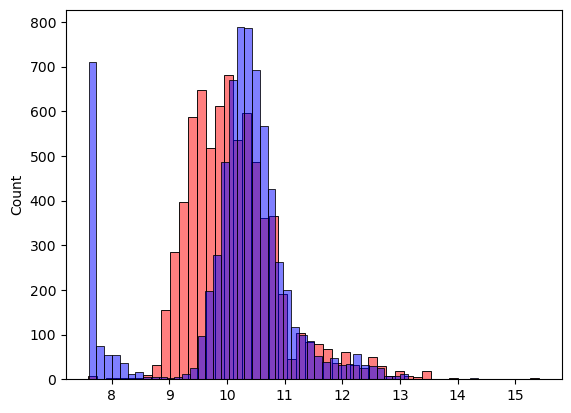

In [97]:
### next snippet shows how to output these two lists accordingly.
# alpha changes the transparency of the bars
# bins specifies the number of bars
sns.histplot(y_pred, color='red', alpha=0.5, bins=50)
sns.histplot(y_train, color='blue', alpha=0.5, bins=50)


## 2.9 RMSE

Source: https://knowmledge.com/2023/09/22/ml-zoomcamp-2023-machine-learning-for-regression-part-8/

In [98]:
# What we did here? Explanation is here: https://knowmledge.com/2023/09/22/ml-zoomcamp-2023-machine-learning-for-regression-part-8/

def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [99]:
# last article we used Seaborn to visualize the performance but now we have an objective metric for the evaluation.
rmse(y_train, y_pred)

np.float64(0.7525939387748007)

## 2.10 Validating the model

Since we don’t know how well the model can apply the learned knowledge to unseen data. So what we want to do now after training the model g on our training dataset, 

we want to apply it on the validation dataset to see how it performs on unseen data. We use RMSE for validating the performance.

In [100]:
base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']
 
X_train = df_train[base].fillna(0).values
 
w0, w = train_linear_regression(X_train, y_train)
 
y_pred = w0 + X_train.dot(w)

Next we implement the prepare_X function. The idea here to provide the same way of preparing the dataset regardless of whether it’s train set, validation set, or test set.

In [101]:
def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

Now we can use this function when we prepare data for the training and for the validation as well. In the training part we only use training dataset to train the model. In the validation part we prepare the validation dataset the same way like before and apply the model. Lastly we compute the rmse.

In [102]:
# Training part:
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

# Validation part:
X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)

# Evaluation part:
rmse(y_val, y_pred)

np.float64(0.7279562317987668)

When we compare the RMSE from training with the value from validation (0.749 vs. 0.764) we see that the model performs similarly well on the seen and unseen data. That is what we have hoped for.

## 2.11 Simple feature engineering

https://knowmledge.com/2023/09/22/ml-zoomcamp-2023-machine-learning-for-regression-part-9/

Suppose we want to develop a new feature based on the existing ones in the feature matrix X. Let’s assume we want to use the year information as an age information. Let’s assume further we have year 2017.

In [105]:
2017 - df_train.year

0       15
1        2
2        0
3        2
4        2
        ..
7145     0
7146     3
7147    20
7148     0
7149     8
Name: year, Length: 7150, dtype: int64

We can add this new feature ‘age’ to our prepare_X function. What is one important remark here. 
It’s a good way to copy the dataframe inside prepare_X. Otherwise while using df you’ll modify the original data, what ist mostly not wanted.

In [107]:
base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']
 
def prepare_X(df):
    df = df.copy()
     
    df['age'] = 2017 - df.year
    features = base + ['age']
     
    df_num = df[features]
    df_num = df_num.fillna(0)
    # extracting the Numpy array
    X = df_num.values
    return X
 
X_train = prepare_X(df_train)
X_train

array([[1.900e+02, 6.000e+00, 1.600e+01, 1.200e+01, 5.490e+02, 1.500e+01],
       [4.200e+02, 8.000e+00, 2.200e+01, 1.500e+01, 1.624e+03, 2.000e+00],
       [1.600e+02, 4.000e+00, 3.600e+01, 2.700e+01, 1.385e+03, 0.000e+00],
       ...,
       [1.720e+02, 6.000e+00, 2.200e+01, 1.700e+01, 3.105e+03, 2.000e+01],
       [3.810e+02, 8.000e+00, 1.700e+01, 1.300e+01, 2.031e+03, 0.000e+00],
       [1.430e+02, 4.000e+00, 2.600e+01, 2.100e+01, 5.860e+02, 8.000e+00]])

The output of the last snippet shows a list of lists. Each list has 6 items, 5 numerical columns and our new ‘age’ column. Let’s train a new model and see how the model performs.

In [109]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
rmse(y_val, y_pred)

np.float64(0.49915630526281113)

We can see an improvement. The rmse decreased from 0.7641972218363384 to 0.5140456385456807. The improvement in the rmse was clear. Let’s see if this improvement can be seen in the plots as well.

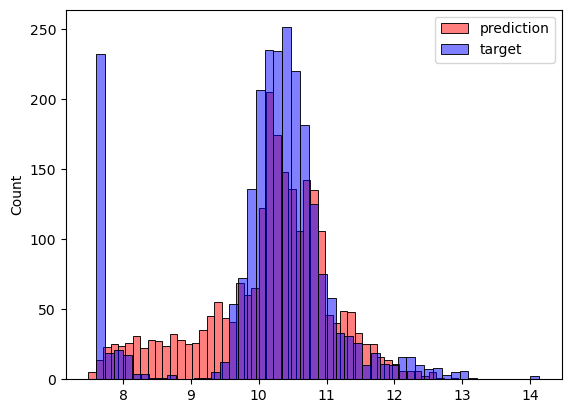

In [110]:
sns.histplot(y_pred, label='prediction', color='red', alpha=0.5, bins=50)
sns.histplot(y_val, label='target', color='blue',  alpha=0.5, bins=50)
plt.legend()

Here, too, a clear improvement can be seen. Many car prices are predicted much better. But there is still space for improvement.

## 2.12 Categorical variables

Source: https://knowmledge.com/2023/09/23/ml-zoomcamp-2023-machine-learning-for-regression-part-10/

Categorical variables are variables that are categories (typically strings) Here: make, model, engine_fuel_type, transmission_type, driven_wheels, market_category, vehicle_size, vehicle_style 

In [111]:
df_train.dtypes

make                  object
model                 object
year                   int64
engine_fuel_type      object
engine_hp            float64
engine_cylinders     float64
transmission_type     object
driven_wheels         object
number_of_doors      float64
market_category       object
vehicle_size          object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
popularity             int64
dtype: object

In [112]:
# But, there is one value that looks like numerical variable, but it isn’t. number_of_doors is not really a numerical number.
df_train.number_of_doors

0       3.0
1       4.0
2       4.0
3       4.0
4       4.0
       ... 
7145    4.0
7146    4.0
7147    2.0
7148    4.0
7149    2.0
Name: number_of_doors, Length: 7150, dtype: float64

In [113]:
df_train.number_of_doors == 2 # Find cars which have 2 doors

0       False
1       False
2       False
3       False
4       False
        ...  
7145    False
7146    False
7147     True
7148    False
7149     True
Name: number_of_doors, Length: 7150, dtype: bool

Typical way of encoding such categorical variables is that we represent it with a bunch of binary columns – so called one-hot encoding. 

We can imitate this encoding by turning the booleans from the last snippet into integers (1 and 0) and creating a new variable for each number of doors.

In [116]:
df_train['num_doors_2'] = (df_train.number_of_doors == 2).astype('int')
df_train['num_doors_3'] = (df_train.number_of_doors == 3).astype('int')
df_train['num_doors_4'] = (df_train.number_of_doors == 4).astype('int')

But we can do this easier with string replacement.

In [119]:
'num_doors_%s' % 4
# Output: 'num_doors_4'
 
# With that replacement we can write a loop
for v in [2, 3, 4]:
    df_train['num_doors_%s' % v] = (df_train.number_of_doors == v).astype('int')


In [120]:
# We delete this because we'll use another solution
for v in [2, 3, 4]:
    del df_train['num_doors_%s' % v]

In [121]:
# Let’s use this string replacement method in our prepare_X function.
def prepare_X(df):
    df = df.copy()
    features = base.copy()
     
    df['age'] = 2017 - df.year
    features.append('age')
     
    for v in [2, 3, 4]:
        df['num_doors_%s' % v] = (df.number_of_doors == v).astype('int')
        features.append('num_doors_%s' % v)
     
    df_num = df[features]
    df_num = df_num.fillna(0)
    # extracting the Numpy array
    X = df_num.values
    return X
 
prepare_X(df_train)


array([[190.,   6.,  16., ...,   0.,   1.,   0.],
       [420.,   8.,  22., ...,   0.,   0.,   1.],
       [160.,   4.,  36., ...,   0.,   0.,   1.],
       ...,
       [172.,   6.,  22., ...,   1.,   0.,   0.],
       [381.,   8.,  17., ...,   0.,   0.,   1.],
       [143.,   4.,  26., ...,   1.,   0.,   0.]])

In [122]:
# Now we can check if the model performance has improved with the new features.
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
rmse(y_val, y_pred)

np.float64(0.500171147535075)

We see in contrast to the last training with rmse of 0.5096109986025086 there is only a slightly improvement (lower is better), almost negligible. So the number of doors feature is not that useful. Maybe the ‘Make’ information is more useful.

In [123]:
df.make.nunique()

48

In [124]:
df.make

0            bmw
1            bmw
2            bmw
3            bmw
4            bmw
          ...   
11909      acura
11910      acura
11911      acura
11912      acura
11913    lincoln
Name: make, Length: 11914, dtype: object

There are 48 unique values in the ‘Make’ column. That could be too much. Let’s look at the most popular ones.

In [125]:
df.make.value_counts().head()

make
chevrolet     1123
ford           881
volkswagen     809
toyota         746
dodge          626
Name: count, dtype: int64

In [126]:
# If we want to get the actual values, we use the index property
df.make.value_counts().head().index

Index(['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge'], dtype='object', name='make')

In [127]:
# Wrap it in a usual Python list
makes = list(df.make.value_counts().head().index)
makes

['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']

In [128]:
# We can now adapt again our prepare_X function to add the new feature.
def prepare_X(df):
    df = df.copy()
    features = base.copy()
     
    df['age'] = 2017 - df.year
    features.append('age')
     
    for v in [2, 3, 4]:
        df['num_doors_%s' % v] = (df.number_of_doors == v).astype('int')
        features.append('num_doors_%s' % v)
         
    for v in makes:
        df['make_%s' % v] = (df.make == v).astype('int')
        features.append('make_%s' % v)
     
    df_num = df[features]
    df_num = df_num.fillna(0)
    # extracting the Numpy array
    X = df_num.values
    return X



In [129]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)
 
X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
 
rmse(y_val, y_pred)

np.float64(0.4950543344294588)

The model performance has once again improved somewhat. How about adding all the other categorical variables now? This should improve the performance even more, right? Let’s try.

In [130]:
categorical_variables = [
    'make', 'engine_fuel_type', 'transmission_type', 'driven_wheels', 
    'market_category', 'vehicle_size', 'vehicle_style'
]
 
# The dictionary category will contain for each of the categories 
# the top 5 most common ones
categories = {}
 
for c in categorical_variables:
    categories[c] = list(df[c].value_counts().head().index)
     
categories

{'make': ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge'],
 'engine_fuel_type': ['regular_unleaded',
  'premium_unleaded_(required)',
  'premium_unleaded_(recommended)',
  'flex-fuel_(unleaded/e85)',
  'diesel'],
 'transmission_type': ['automatic',
  'manual',
  'automated_manual',
  'direct_drive',
  'unknown'],
 'driven_wheels': ['front_wheel_drive',
  'rear_wheel_drive',
  'all_wheel_drive',
  'four_wheel_drive'],
 'market_category': ['crossover',
  'flex_fuel',
  'luxury',
  'luxury,performance',
  'hatchback'],
 'vehicle_size': ['compact', 'midsize', 'large'],
 'vehicle_style': ['sedan',
  '4dr_suv',
  'coupe',
  'convertible',
  '4dr_hatchback']}

In [131]:
# The next snippet shows how to implement the new features to our prepare_X function. This time we need two loops as described inline.

def prepare_X(df):
    # this is good way to do, otherwise while using df you'll modify the original data
    # what is mostly not wanted
    df = df.copy()
    features = base.copy()
     
    df['age'] = 2017 - df.year
    features.append('age')
     
    for v in [2, 3, 4]:
        df['num_doors_%s' % v] = (df.number_of_doors == v).astype('int')
        features.append('num_doors_%s' % v)
 
    # First loop is for each key of the dictionary categories.
    # Second loop is for each value inside the categories
    # For each of this values we create a new column.
    for c, values in categories.items():    
        for v in values:
            df['%s_%s' % (c, v)] = (df[c] == v).astype('int')
            features.append('%s_%s' % (c, v))
     
    df_num = df[features]
    df_num = df_num.fillna(0)
    # extracting the Numpy array
    X = df_num.values
    return X

In [132]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)
 
X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
 
rmse(y_val, y_pred)

np.float64(23.866788729069707)

This time the model performance is very bad. As you can see the RMSE (3.1033420378110214e) is very large. So something went wrong. We will see in next

## 2.13 Regularization

In [ ]:
# Source: https://knowmledge.com/2023/09/23/ml-zoomcamp-2023-machine-learning-for-regression-part-11/

The topic for this part is regularization as a way to solve the problem of duplicated columns in our data. Remember the formula for normal equation is: w = (X^TX)^-1*X^Ty
The problem what we have is connected with the first part (X^TX)^-1. We need to take an inverse of the GRAM matrix. Sometimes this inverse doesn’t exist. This happens when there are duplicate features in X. Let's see an example

In [134]:
# # You see here 2nd and 3rd columns are identical
X = [
    [4, 4, 4],
    [3, 5, 5],
    [5, 1, 1],
    [5, 4, 4],
    [7, 5, 5],
    [4, 5, 5]
]

X = np.array(X)
X

array([[4, 4, 4],
       [3, 5, 5],
       [5, 1, 1],
       [5, 4, 4],
       [7, 5, 5],
       [4, 5, 5]])

In [135]:
XTX = X.T.dot(X)
XTX

array([[140, 111, 111],
       [111, 108, 108],
       [111, 108, 108]])

In [136]:
# np.linalg.inv(XTX) 

The code from the last article didn’t raise that error, so the inverse of that gram matrix exists. But the reason for the very big value for rmse is that our data is not very clean.

Let’s go back to our last example but this time similar X as before with a few noise.

In [141]:
X = [
    [4, 4, 4],
    [3, 5, 5],
    [5, 1, 1],
    [5, 4, 4],
    [7, 5, 5],
    [4, 5, 5.0000001],
]
 
X = np.array(X)
y = [1, 2, 3, 1, 2, 3]
 
XTX = X.T.dot(X)
XTX
 
XTX_inv = np.linalg.inv(XTX)
XTX_inv

array([[ 3.92646538e-02, -1.54615164e+05,  1.54615122e+05],
       [-1.54615170e+05,  3.51843724e+13, -3.51843721e+13],
       [ 1.54615129e+05, -3.51843721e+13,  3.51843718e+13]])

In [142]:
w = XTX_inv.dot(X.T).dot(y)
w

array([ 3.25115862e-01, -4.41093100e+06,  4.41093113e+06])

In [143]:
# Adding a small number to the diagonal
# helps to control. So the numbers of w become smaller
XTX = [
    [1.0001, 2, 2],
    [2,     1.0001, 1.0000001],
    [2, 1.0000001, 1.0001]
]

XTX = np.array(XTX)
np.linalg.inv(XTX)

array([[-3.33366691e-01,  3.33350007e-01,  3.33350007e-01],
       [ 3.33350007e-01,  5.00492166e+03, -5.00508835e+03],
       [ 3.33350007e-01, -5.00508835e+03,  5.00492166e+03]])

In [144]:
XTX = [
    [1.01, 2, 2],
    [2,   1.01, 1.0000001],
    [2, 1.0000001,   1.01]
]
 
XTX = np.array(XTX)
np.linalg.inv(XTX)

array([[ -0.33668908,   0.33501399,   0.33501399],
       [  0.33501399,  49.91590897, -50.08509104],
       [  0.33501399, -50.08509104,  49.91590897]])

In [145]:
XTX = [
    [1, 2, 2],
    [2, 1, 1.0000001],
    [2, 1.0000001, 1]
]
 
XTX =  np.array(XTX)
XTX

array([[1.       , 2.       , 2.       ],
       [2.       , 1.       , 1.0000001],
       [2.       , 1.0000001, 1.       ]])

In [146]:
# Remember there was the eye function to get an Identity matrix. Maybe we can use this…
np.eye(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [147]:
# When adding XTX to this matrix, it adds one on the diagonal
XTX + np.eye(3)

array([[2.       , 2.       , 2.       ],
       [2.       , 2.       , 1.0000001],
       [2.       , 1.0000001, 2.       ]])

In [148]:
# We can multiply this eye by a smal number
XTX = XTX + 0.01 * np.eye(3)
XTX

array([[1.01     , 2.       , 2.       ],
       [2.       , 1.01     , 1.0000001],
       [2.       , 1.0000001, 1.01     ]])

In [149]:
# XTX = XTX + 0.1*np.eye(3)
# XTX

In [150]:
# XTX = XTX + 1*np.eye(3)
# XTX

In [151]:
np.linalg.inv(XTX)

array([[ -0.33668908,   0.33501399,   0.33501399],
       [  0.33501399,  49.91590897, -50.08509104],
       [  0.33501399, -50.08509104,  49.91590897]])

In [152]:
### This leads us to reimplementing the train_linear_regression function again
# reg = regularized
# parameter r = short for regularization
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [153]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression_reg(X_train, y_train, r=0.01)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
rmse(y_val, y_pred)

np.float64(0.44876483506148446)

## 2.14 Tuning the model

Source: https://knowmledge.com/2023/09/24/ml-zoomcamp-2023-machine-learning-for-regression-part-12/

In [154]:
for r in [0.0, 0.00001, 0.0001, 0.001, 0.1, 1, 10]:
    X_train = prepare_X(df_train)
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)

    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    
    print("reg parameter: ",r, "bias term: ",w0, "rmse: ",score)

reg parameter:  0.0 bias term:  -3258688534102859.5 rmse:  23.866788729069707
reg parameter:  1e-05 bias term:  7.5132348790758465 rmse:  0.44876225237043876
reg parameter:  0.0001 bias term:  6.218107945923603 rmse:  0.4487622735508857
reg parameter:  0.001 bias term:  6.228696802317706 rmse:  0.4487625036873416
reg parameter:  0.1 bias term:  6.109503282409427 rmse:  0.44878993865473865
reg parameter:  1 bias term:  5.5007750834985085 rmse:  0.44921520419057853
reg parameter:  10 bias term:  4.244122476227936 rmse:  0.46087318990123866


In [155]:
r = 0.001
X_train = prepare_X(df_train)
w0, w = train_linear_regression_reg(X_train, y_train, r=r)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
score = rmse(y_val, y_pred)
print("rmse: ",score)

rmse:  0.4487625036873416


## 2.15 Using the model

### Combining datasets
First step to do is getting our data. So we need to combine df_train and df_val into one dataset. We can use Pandas concat() function that takes a list of dataframes and concatenates them together.

In [156]:
df_full_train = pd.concat([df_train, df_val])

We also need to concatenate y_train and y_val to get y_full_train. This time we use the concatenate function of NumPy library.

In [157]:
y_full_train = np.concatenate([y_train, y_val])

In [158]:
y_full_train

array([ 9.8871549 , 11.43253937, 10.05302762, ..., 10.07895232,
        7.60140233, 10.94024217])

### Resetting index
When combining two dataframes it can happen that the index is not sequential. Here you can use an already known function and reset the index.

In [159]:
df_full_train = df_full_train.reset_index(drop=True)

### Getting feature matrix X
Now we have again a coherent dataset for training and we can prepare it for the usage as we did before. The prepare_X() function still works fine.

In [160]:
X_full_train = prepare_X(df_full_train)

In [161]:
X_full_train

array([[190.,   6.,  16., ...,   0.,   0.,   0.],
       [420.,   8.,  22., ...,   0.,   0.,   0.],
       [160.,   4.,  36., ...,   0.,   0.,   0.],
       ...,
       [203.,   6.,  19., ...,   0.,   0.,   0.],
       [100.,   4.,  29., ...,   0.,   0.,   1.],
       [290.,   6.,  26., ...,   0.,   0.,   0.]])

### Train the final model
Next step is to train the final model on the combined dataset. We’re using the new train_linear_regression_reg() function to get the value for w0 and the vector w.

In [162]:
w0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)
w0, w

(np.float64(6.248576101044916),
 array([ 1.45562338e-03,  1.20181354e-01, -7.23863322e-03, -6.38906967e-03,
        -5.08344251e-05, -9.66466035e-02, -5.67797268e-01, -7.02252869e-01,
        -4.19315947e-01, -1.88616033e-02,  1.73851375e-01,  2.63229127e-03,
        -1.03604111e-01, -8.73117893e-02, -4.70373134e-01,  9.25245658e-02,
        -3.09469218e-01, -5.54467493e-01, -6.68458596e-02,  1.03699979e+00,
         8.59659102e-01,  1.09147446e+00,  2.79346953e+00,  4.70186432e-01,
         1.61485723e+00,  1.51424787e+00,  1.60621591e+00,  1.51354210e+00,
        -9.47260446e-02,  5.10393908e-02, -4.91196653e-02, -3.32267842e-02,
        -5.92433630e-03,  2.16297077e+00,  2.05245238e+00,  2.03364576e+00,
        -4.15934120e-02,  4.31870818e-02,  1.59601912e-01,  3.13099964e-01,
        -1.63086647e-01]))

### Applying model to test data
Now is the great moment for the final model. It must pass the final test. For this purpose we use test data, which are again prepared with the prepare_X() function. Then the model is applied to the test data and the RMSE can be calculated.

In [163]:
X_test = prepare_X(df_test)
y_pred = w0 + X_test.dot(w)

score = rmse(y_test, y_pred)

print("rmse: ", score)

rmse:  0.469939383817924


RMSE_test = 0.46061734034842283 is not so far away from RMSE_val = 0.4549809533999964. That means the model generalizes quite well and it didn’t get this score by chance. Now we have our final model and we can use it. The way we want to use it is to predict the price of an (unseen) car – unseen means here that the model hasn’t seen this car during training.

### Using the model
Using the model means:

- Extracting all the features (getting feature vector of the car)
- Applying our final model to this feature vector & predicting the price

#### Feature Extraction
For this step we can take any car from our test dataset and pretend it’s a new car. Let’s just take one car.

In [164]:
df_test.iloc[20]

make                                           ford
model                                          edge
year                                           2015
engine_fuel_type     premium_unleaded_(recommended)
engine_hp                                     245.0
engine_cylinders                                4.0
transmission_type                         automatic
driven_wheels                       all_wheel_drive
number_of_doors                                 4.0
market_category                           crossover
vehicle_size                                midsize
vehicle_style                               4dr_suv
highway_mpg                                      28
city_mpg                                         20
popularity                                     5657
Name: 20, dtype: object

Usually the way we do it is that we don’t get a dataframe here. But it could be a Python dictionary with all the information about the car. In real life you can imagine a website or an app, where people enter all the values. Then the website sends the request with all the information (as dictionary) to the model. The model replies back with the predicted price.

In [165]:
# For this example we turn this data of our car into a dictionary.
car = df_test.iloc[20].to_dict()
car

{'make': 'ford',
 'model': 'edge',
 'year': 2015,
 'engine_fuel_type': 'premium_unleaded_(recommended)',
 'engine_hp': 245.0,
 'engine_cylinders': 4.0,
 'transmission_type': 'automatic',
 'driven_wheels': 'all_wheel_drive',
 'number_of_doors': 4.0,
 'market_category': 'crossover',
 'vehicle_size': 'midsize',
 'vehicle_style': '4dr_suv',
 'highway_mpg': 28,
 'city_mpg': 20,
 'popularity': 5657}

In [166]:
# The car is our request and now remember the prepare_X function expects a dataframe, so we need to create a dataframe with a single row for our request.
df_small = pd.DataFrame([car])
df_small

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity
0,ford,edge,2015,premium_unleaded_(recommended),245.0,4.0,automatic,all_wheel_drive,4.0,crossover,midsize,4dr_suv,28,20,5657


In [167]:
# We can use this single row DataFrame as input for the prepare_X() function to get the feature matrix. In this case our feature matrix is a feature vector.
X_small = prepare_X(df_small)

#### Predicting the price
The final step is to apply the final model to our requested car (feature vector) and predict the price.

In [168]:
y_pred = w0 + X_small.dot(w)
# Don't need an array but it's first (and only) item
y_pred = y_pred[0]
y_pred

np.float64(10.363797895288435)

10.34 is still not the price in $. To get the real price we need to undo the logarithm.

In [169]:
np.expm1(y_pred)

np.float64(31690.313343317925)

After undoing the logarithm we get the price in $. 

So we think that a car with these characteristics should cost  $30,973.55.

In [170]:
# Lastly to get an evaluation about model performance let’s compare the predicted price to the actual price of this requested car
np.expm1(y_test[20])

np.float64(30094.999999999975)

In [171]:
# Original price is $50,549.99; not bad prediction comparatively $30,973.55 

## 2.16 Next steps

* We included only 5 top features. What happens if we include 10?

Other projects

* Predict the price of a house - e.g. boston dataset
* https://archive.ics.uci.edu/ml/datasets.php?task=reg
* https://archive.ics.uci.edu/ml/datasets/Student+Performance

## 2.17 Summary

* EDA - looking at data, finding missing values
* Target variable distribution - long tail => bell shaped curve
* Validation framework: train/val/test split (helped us detect problems)
* Normal equation - not magic, but math
* Implemented it with numpy
* RMSE to validate our model
* Feature engineering: age, categorical features
* Regularization to fight numerical instability